## Experimental Functions for Cumulative Entropy and Mutual Information

These functions compute the mutual information based on the cumulative distribution function rather than the density as it is done in traditional definitions.

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.stats import pearsonr
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}
random.seed(4408765) 
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import numpy2ri
ro.conversion.py2ri = numpy2ri
from rpy2.robjects.packages import importr
mass = importr("MASS")

ImportError: /home/nina/anaconda3/lib/libgomp.so.1: version `GOMP_4.0' not found (required by /usr/lib/R/lib/libR.so)

In [ ]:
def xy_cor(N, rho, truncate=True):
    "This function generates two N-element Gaussian random vectors with correlation rho"
    xx = np.array([0, 1])
    yy = np.array([0, 1])
    means = [0, 1]  
    stds = [0.5, 0.5]
    covs = [[stds[0]**2, stds[0]*stds[1]*rho], 
        [stds[0]*stds[1]*rho, stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
    x = (m[0] - np.mean(m[0]))/np.std(m[0])
    y = (m[1] - np.mean(m[1]))/np.std(m[1])
    if (truncate == True):
        x = (x - np.min(x))/(np.max(x) - np.min(x))
        y = (y - np.min(y))/(np.max(y) - np.min(y))
        thres = 3
        for i in range(N):
            if x[i] > thres:
                x[i] = thres
            if x[i] < -thres:
                x[i] = -thres
            if y[i] > thres:
                y[i] = thres
            if y[i] < -thres:
                y[i] = -thres  
    return (x, y)

### Define the Cumulative Mutual Information function based on the difference between joint and marginal Cumulative Entropies

$$CMI(x, y) = (max(x) - \bar{x}) CE(y) + (max(y) - \bar{y}) CE(x) - CE(x, y)$$

In [ ]:
def CMI_diff(x, y):
    "This function computes the Cumulative Mutual Information based on the difference between joint and marginals CE's"
    x = x - np.mean(x)
    y = y - np.mean(y)
    N = len(x)
    lattice_x = np.zeros((N, N), dtype="float_")    # Array of lower x tile coordinates
    lattice_y = np.zeros((N, N), dtype="float_")     # Array of lower y tile coordinates
    lattice_area = np.zeros((N, N), dtype="float_")   # Array of tile areas
    lattice_count = np.zeros((N, N), dtype="uint8")    # Array of tile data counts
    x_order = np.argsort(x, kind='quicksort')
    x_sorted = x[x_order]
    y_order = np.argsort(y, kind='quicksort')
    y_sorted = y[y_order]
    ind = np.arange(0, N, 1)
    ind_x_order = np.argsort(x_order, kind='quicksort') 
    ind_x = ind[ind_x_order]
    ind_y_order = np.argsort(y_order, kind='quicksort') 
    ind_y = ind[ind_y_order]
    for i in range(N):
        for j in range(N):
            lattice_x[i, j] = x_sorted[i]
            lattice_y[i, j] = y_sorted[j]
            if i < (N-1) and j < (N-1):
                lattice_area[i, j] = (x_sorted[i+1] - x_sorted[i])*(y_sorted[j+1] - y_sorted[j])
        
    for i in range(N): 
        lattice_count[ind_x[i], ind_y[i]] = 1 

    np.cumsum(lattice_count, axis=1, out=lattice_count)
    np.cumsum(lattice_count, axis=0, out=lattice_count)
    CDF_xy = lattice_count/float(N)
    CDF_x = np.arange(0, N, 1)/float(N)
    CDF_y = CDF_x
    CE_x = 0
    CE_y = 0
    for i in range(N-1):
        if CDF_x[i] != 0:
            CE_x = CE_x - (x_sorted[i+1] - x_sorted[i]) * CDF_x[i] * math.log(CDF_x[i])
        if CDF_y[i] != 0:       
            CE_y = CE_y - (y_sorted[i+1] - y_sorted[i]) * CDF_y[i] * math.log(CDF_y[i])

    CE_xy = 0
    for i in range(N):
        for j in range(N):
            if CDF_xy[i, j] != 0:
                CE_xy = CE_xy - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
    # Compute the CMI based on the difference between joint and marginals CE's        
            
    CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  
    #if CMI < 0:
    #    CMI = 0

    rho, p = pearsonr(x, y)
    
    #return (np.sign(rho)* CMI/(np.max(x)*np.max(y)))
    return (CMI/(np.max(x)*np.max(y)))

In [2]:
def CMI_diff_smooth(x, y, g=50):
    "This function computes the Cumulative Mutual Information based on the difference between joint and marginals CE's"
    
    x = x - np.mean(x)
    y = y - np.mean(y)

    N = len(x)
   
    x_r = ((x - min(x))/(max(x) - min(x)))*g
    y_r = ((y - min(y))/(max(y) - min(y)))*g
    lattice_count_x = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_y = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_xy = np.zeros((g+1, g+1), dtype="uint8")    # Array of tile data counts

    for i in range(N):
        x_index = np.floor(x_r[i])
        y_index = np.floor(y_r[i])  
        #    print(x_r[i], x_index)
        lattice_count_x[x_index] = lattice_count_x[x_index] + 1
        lattice_count_y[y_index] = lattice_count_y[y_index] + 1   
        lattice_count_xy[x_index, y_index] =lattice_count_xy[x_index, y_index] + 1
    
    x_segment_length = ((max(x) - min(x))/g) 
    y_segment_length = ((max(y) - min(y))/g)
    lattice_area = x_segment_length * y_segment_length 
    np.cumsum(lattice_count_x, out=lattice_count_x)  
    np.cumsum(lattice_count_y, out=lattice_count_y)     
    np.cumsum(lattice_count_xy, axis=1, out=lattice_count_xy)
    np.cumsum(lattice_count_xy, axis=0, out=lattice_count_xy)

    CDF_x = lattice_count_x/float(N)
    CDF_y = lattice_count_y/float(N)
    CDF_xy = lattice_count_xy/float(N)

    CE_x = CE_y = 0
    for i in range(g):
        if CDF_x[i] != 0:
            CE_x = CE_x - x_segment_length * CDF_x[i] * math.log(CDF_x[i])
        if CDF_y[i] != 0:       
            CE_y = CE_y - y_segment_length * CDF_y[i] * math.log(CDF_y[i])

    CE_xy = 0
    for i in range(g):
        for j in range(g):
            if CDF_xy[i, j] != 0:
                CE_xy = CE_xy - lattice_area * CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
        # Compute the CMI based on the difference between joint and marginals CE's        
            
    CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  

    rho, p = pearsonr(x, y)
    
    return (CMI/(np.max(x)*np.max(y)))

### Define the Cumulative Mutual Information function based on the ratio of joint and marginal Cumulative Entropies

$$CMI(x, y) = \int \int P(x,y) \log \left ( \frac{P(x,y)}{P(x)P(y)} \right ) dx dy$$

In [3]:
def CMI_ratio(x, y):
    "This function computes the Cumulative Mutual Information based on the ratio of joint and marginals CE's"      
    x = x - np.mean(x)
    y = y - np.mean(y)
    N = len(x)
    lattice_x = np.zeros((N, N), dtype="float_")    # Array of lower x tile coordinates
    lattice_y = np.zeros((N, N), dtype="float_")     # Array of lower y tile coordinates
    lattice_area = np.zeros((N, N), dtype="float_")   # Array of tile areas
    lattice_count = np.zeros((N, N), dtype="uint8")    # Array of tile data counts
    x_order = np.argsort(x, kind='quicksort')
    x_sorted = x[x_order]
    y_order = np.argsort(y, kind='quicksort')
    y_sorted = y[y_order]
    ind = np.arange(0, N, 1)
    ind_x_order = np.argsort(x_order, kind='quicksort') 
    ind_x = ind[ind_x_order]
    ind_y_order = np.argsort(y_order, kind='quicksort') 
    ind_y = ind[ind_y_order]
    for i in range(N):
        for j in range(N):
            lattice_x[i, j] = x_sorted[i]
            lattice_y[i, j] = y_sorted[j]
            if i < (N-1) and j < (N-1):
                lattice_area[i, j] = (x_sorted[i+1] - x_sorted[i])*(y_sorted[j+1] - y_sorted[j])
        
    for i in range(N): 
        lattice_count[ind_x[i], ind_y[i]] = 1 

    np.cumsum(lattice_count, axis=1, out=lattice_count)
    np.cumsum(lattice_count, axis=0, out=lattice_count)
    CDF_xy = lattice_count/float(N)
    CDF_x = np.arange(0, N, 1)/float(N)
    CDF_y = CDF_x
    
    # Compute the CMI based on the ratio of joint and marginals CE's
    
    CMI = 0
    for i in range(N):
        for j in range(N):
            if CDF_x[i] != 0 and CDF_y[j] != 0 and CDF_xy[i, j] != 0:
                # CMI = CMI - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])/(CDF_x[i]*CDF_y[j])
                CMI = CMI - lattice_area[i, j] * CDF_xy[i, j] * (math.log(CDF_xy[i, j]) - math.log(CDF_x[i]) - math.log(CDF_y[j]))
        
    rho, p = pearsonr(x, y)
        
    # return (np.sign(rho) * CMI/(np.max(x)*np.max(y)))
    return (np.sign(rho) * CMI)

In [4]:
def CMI_ratio_smooth(x, y, g=50):
    "This function computes the Cumulative Mutual Information based on the ratio between joint and marginals CE's"
    
    x = x - np.mean(x)
    y = y - np.mean(y)

    N = len(x)
   
    x_r = ((x - min(x))/(max(x) - min(x)))*g
    y_r = ((y - min(y))/(max(y) - min(y)))*g
    lattice_count_x = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_y = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_xy = np.zeros((g+1, g+1), dtype="uint8")    # Array of tile data counts

    for i in range(N):
        x_index = np.floor(x_r[i])
        y_index = np.floor(y_r[i])  
        #    print(x_r[i], x_index)
        lattice_count_x[x_index] = lattice_count_x[x_index] + 1
        lattice_count_y[y_index] = lattice_count_y[y_index] + 1   
        lattice_count_xy[x_index, y_index] = lattice_count_xy[x_index, y_index] + 1
    
    x_segment_length = ((max(x) - min(x))/g) 
    y_segment_length = ((max(y) - min(y))/g)
    lattice_area = x_segment_length * y_segment_length 
    np.cumsum(lattice_count_x, out=lattice_count_x)  
    np.cumsum(lattice_count_y, out=lattice_count_y)     
    np.cumsum(lattice_count_xy, axis=1, out=lattice_count_xy)
    np.cumsum(lattice_count_xy, axis=0, out=lattice_count_xy)

    CDF_x = lattice_count_x/float(N)
    CDF_y = lattice_count_y/float(N)
    CDF_xy = lattice_count_xy/float(N)

# Compute the CMI based on the ratio of joint and marginals CE's
    
    CMI = 0
    for i in range(g):
        for j in range(g):
            if CDF_x[i] != 0 and CDF_y[j] != 0 and CDF_xy[i, j] != 0:
                CMI = CMI - lattice_area * CDF_xy[i, j] * math.log(CDF_xy[i, j])/(CDF_x[i]*CDF_y[j])
        
    rho, p = pearsonr(x, y)
        
    return (np.sign(rho) * CMI)


### Functions for kernel-based Information Coefficient

In [21]:
def rbcv(x):
    """
    :param x: array-like, (n_samples,)
    :return: float, bandwidth
    """
    bandwidth = np.array(mass.bcv(x))[0]
    return bandwidth


def compute_mutual_information(x, y, n_grid=25, var_types='cc', bandwidth_scaling=None):
    """
    :param x: array-like, (n_samples,)
    :param y: array-like, (n_samples,)
    :param n_grid: int, number of grid points at which to evaluate kernel density
    :param var_types: two-character string of 'c' (continuous) or 'd' (discrete)
    :param bandwidth_scaling: float
    :return: float, mutual information

    Notes
    -----
    Difference in bandwidth convention means bcv() delta must be divided by 4
    Todo: Bandwidth selection method as robust and fast as R bcv() without invoking R. Maybe in Cython or C.
    """
    x_set = np.logical_not(np.isnan(x))
    y_set = np.logical_not(np.isnan(y))
    overlap = x_set & y_set
    n_overlap = overlap.sum()
    jitter_scale = 1E-10
    x_jitter, y_jitter = [jitter_scale * np.random.uniform(size=n_overlap) for _ in [x, y]]
    x = x[overlap] + x_jitter
    y = y[overlap] + y_jitter
    xy = [x, y]
    x_grid = np.linspace(x.min(), x.max(), n_grid)
    y_grid = np.linspace(y.min(), y.max(), n_grid)
    xg, yg = np.meshgrid(x_grid, y_grid)
    grid = np.vstack([xg.flatten(), yg.flatten()])
    delta = np.array([rbcv(z) for z in [x, y]]).reshape((2,)) / 4
    if bandwidth_scaling:
        delta *= bandwidth_scaling
    kde = KDEMultivariate(xy, bw=delta, var_type=var_types)
    fxy = kde.pdf(grid).reshape((n_grid, n_grid)).T + np.finfo(float).eps
    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]
    pxy = fxy / (fxy.sum() * dx * dy)
    px = pxy.sum(axis=0) * dy
    py = pxy.sum(axis=1) * dx
    pxg, pyg = np.meshgrid(px, py)
    # cumsums for x and y
    
    mi = np.sum(pxy * np.log(pxy / (pxg * pyg))) * dx * dy
    return mi


def compute_information_coefficient(x, y, n_grid=25, var_types='cc'):
    """
    :param x: array-like, (n_samples,)
    :param y: array-like, (n_samples,)
    :param n_grid: int, number of grid points at which to evaluate kernel density
    :param var_types: two-character string of 'c' (continuous) or 'd' (discrete)
    :return: float, information coefficient
    """
    rho, p = pearsonr(x, y)
    rho2 = abs(rho)
    bandwidth_scaling = (1 + (-0.75)*rho2)
    mi = compute_mutual_information(x, y, n_grid, var_types, bandwidth_scaling)
    ic = np.sign(rho) * np.sqrt(1 - np.exp(- 2 * mi))
    return ic



### Generate correlated random data for incremental values of the correlation between x and y

In [22]:
N = 300
inst = 1

corrs = np.arange(-1, 1, 0.05)
T = len(corrs)
CMI_aver_diff = np.zeros((T), dtype="float_") 
CMI_aver_diff_smooth = np.zeros((T), dtype="float_")
CMI_aver_ratio = np.zeros((T), dtype="float_") 
CMI_aver_ratio_smooth = np.zeros((T), dtype="float_")

IC_aver = np.zeros((T), dtype="float_") 

for t in range(T):
    CMI_diff_vals = np.zeros(inst, dtype="float_") 
    CMI_diff_smooth_vals = np.zeros(inst, dtype="float_")    
    CMI_ratio_vals = np.zeros(inst, dtype="float_") 
    CMI_ratio_smooth_vals = np.zeros(inst, dtype="float_")    
    IC_vals = np.zeros(inst, dtype="float_")
    for k in range(inst):
        (x, y) = xy_cor(N, corrs[t], truncate=False)        
        CMI_diff_vals[k] = CMI_diff(x, y)  
        CMI_diff_smooth_vals[k] = CMI_diff_smooth(x, y, g=15)  
        CMI_ratio_vals[k] = CMI_ratio(x, y)
        CMI_ratio_smooth_vals[k] = CMI_ratio_smooth(x, y, g=15) 
        
        IC_vals[k] = compute_information_coefficient(x, y)
  
    CMI_aver_diff[t] = np.mean(CMI_diff_vals)
    CMI_aver_diff_smooth[t] = np.mean(CMI_diff_smooth_vals)
    CMI_aver_ratio[t] = np.mean(CMI_ratio_vals)
    CMI_aver_ratio_smooth[t] = np.mean(CMI_ratio_smooth_vals)
    
    IC_aver[t] = np.mean(IC_vals)

NameError: name 'xy_cor' is not defined

In [23]:
 (x, y) = xy_cor(N, 0.7, truncate=False)    

NameError: name 'xy_cor' is not defined

In [24]:
CMI_diff(x, y)  

NameError: name 'CMI_diff' is not defined

In [9]:
CMI_diff_smooth(x, y, g=10) 

NameError: name 'x' is not defined

In [10]:
CMI_ratio_smooth(x, y, g=10) 

NameError: name 'x' is not defined

## Results using the CMI diff metric

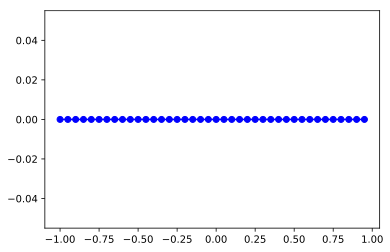

In [11]:
plt.plot(corrs, CMI_aver_diff, 'bo-')

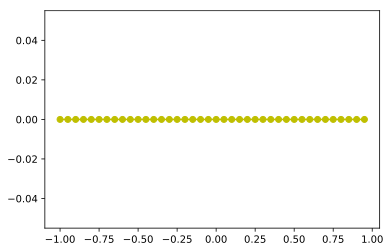

In [12]:
plt.plot(corrs, CMI_aver_diff_smooth, 'yo-')

## Results using the CMI ratio metric

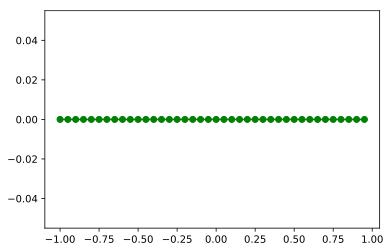

In [13]:
plt.plot(corrs, CMI_aver_ratio, 'go-')

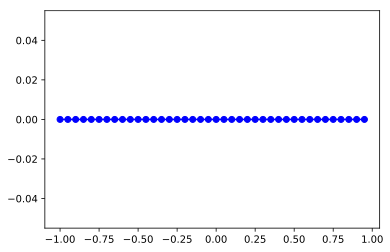

In [14]:
plt.plot(corrs, CMI_aver_ratio_smooth, 'bo-')

## Results using the IC metric

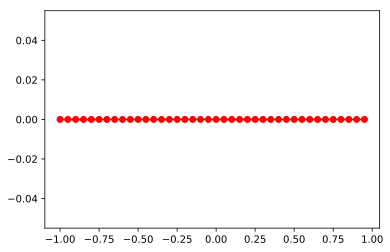

In [15]:
plt.plot(corrs, IC_aver, 'ro-')

### Basic timings

In [16]:
x = np.random.uniform(low=0.0, high=1.0, size=200)
y = np.random.uniform(low=0.0, high=1.0, size=200)

N = 100
start_time = time.time()
for i in range(N):
    z = CMI_diff(x, y)

end_time = time.time() 
print("CMI_diff: Execution time %s seconds per function call " % ((end_time - start_time)/N))

start_time = time.time()
for i in range(N):
    z = CMI_ratio(x, y)

end_time = time.time() 
print("CMI_ratio: Execution time %s seconds per function call " % ((end_time - start_time)/N))

start_time = time.time()
for i in range(N):
    z = compute_information_coefficient(x, y)

end_time = time.time() 
print("IC: Execution time %s seconds per function call " % ((end_time - start_time)/N))


NameError: name 'CMI_diff' is not defined

### References: 

Di Crescenzo and Longobardi. On cumulative entropies. Journal of Statistical Planning and Inference 12/2009; 139:4072-4087.
https://www.researchgate.net/publication/48191880_On_cumulative_entropies

In [ ]:
N = 20
(x, y) = xy_cor(N, 0.7, truncate=False) 
print(CMI_diff(x, y))

x = x - np.mean(x)
y = y - np.mean(y)

N = len(x)
g=50    
x_r = ((x - min(x))/(max(x) - min(x)))*g
y_r = ((y - min(y))/(max(y) - min(y)))*g
lattice_count_x = np.zeros(g+1, dtype="uint8")    # Array of line data counts
lattice_count_y = np.zeros(g+1, dtype="uint8")    # Array of line data counts
lattice_count_xy = np.zeros((g+1, g+1), dtype="uint8")    # Array of tile data counts

for i in range(N):
    x_index = np.floor(x_r[i])
    y_index = np.floor(y_r[i])  
#    print(x_r[i], x_index)
    lattice_count_x[x_index] = lattice_count_x[x_index] + 1
    lattice_count_y[y_index] = lattice_count_y[y_index] + 1   
    lattice_count_xy[x_index, y_index] =lattice_count_xy[x_index, y_index] + 1
    
x_segment_length = ((max(x) - min(x))/g) 
y_segment_length = ((max(y) - min(y))/g)
lattice_area = x_segment_length * y_segment_length 
np.cumsum(lattice_count_x, out=lattice_count_x)  
np.cumsum(lattice_count_y, out=lattice_count_y)     
np.cumsum(lattice_count_xy, axis=1, out=lattice_count_xy)
np.cumsum(lattice_count_xy, axis=0, out=lattice_count_xy)

CDF_x = lattice_count_x/float(N)
CDF_y = lattice_count_y/float(N)
CDF_xy = lattice_count_xy/float(N)

CE_x = CE_y = 0
for i in range(g):
    if CDF_x[i] != 0:
        CE_x = CE_x - x_segment_length * CDF_x[i] * math.log(CDF_x[i])
    if CDF_y[i] != 0:       
        CE_y = CE_y - y_segment_length * CDF_y[i] * math.log(CDF_y[i])

CE_xy = 0
for i in range(g):
    for j in range(g):
        if CDF_xy[i, j] != 0:
            CE_xy = CE_xy - lattice_area * CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
    # Compute the CMI based on the difference between joint and marginals CE's        
            
CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  

rho, p = pearsonr(x, y)
    
print(CMI/(np.max(x)*np.max(y)))


In [17]:
CDF_xy


NameError: name 'CDF_xy' is not defined

In [18]:

    N = len(x)
    
    x_r = ((x-min(x))/(max(x)-min(x)))*g
    y_r = ((y-min(y))/(max(y)-min(y)))*g
 
    lattice_count_x = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_y = np.zeros(g+1, dtype="uint8")    # Array of line data counts
    lattice_count_xy = np.zeros((g+1, g+1), dtype="uint8")    # Array of tile data counts

    for i in range(N):
        x_index = np.ceil(x_r[i])
        y_index = np.ceil(y_r[i])    
        lattice_count_x[x_index] = 1 
        lattice_count_y[y_index] = 1   
        lattice_count_xy[x_index, y_index] = 1         

    np.cumsum(lattice_count_x, out=lattice_count_x)  
    np.cumsum(lattice_count_y, out=lattice_count_y)     
    np.cumsum(lattice_count_xy, axis=1, out=lattice_count_xy)
    np.cumsum(lattice_count_xy, axis=0, out=lattice_count_xy)

    CDF_x = lattice_count_x/float(N)
    CDF_y = lattice_count_y/float(N)
    CDF_xy = lattice_count_xy/float(N)
    
    CE_x = CE_y = 0
    for i in range(g):
        if CDF_x[i] != 0:
            CE_x = CE_x - CDF_x[i] * math.log(CDF_x[i])
        if CDF_y[i] != 0:       
            CE_y = CE_y - CDF_y[i] * math.log(CDF_y[i])

    CE_xy = 0
    for i in range(g):
        for j in range(g):
            if CDF_xy[i, j] != 0:
                CE_xy = CE_xy - CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
    # Compute the CMI based on the difference between joint and marginals CE's        
            
    CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  

    rho, p = pearsonr(x, y)
    
    return (CMI/(np.max(x)*np.max(y)))

IndentationError: unexpected indent (<ipython-input-18-01f0e74c3d84>, line 2)

In [19]:
import pandas.rpy.common

/home/nina/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  if __name__ == '__main__':


ImportError: /home/nina/anaconda3/lib/libgomp.so.1: version `GOMP_4.0' not found (required by /usr/lib/R/lib/libR.so)